In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint,EarlyStopping
import datetime
from keras import regularizers
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split

In [2]:
# Configure kaggle
os.chdir('/root/')
!mkdir -p .kaggle
os.chdir('/root/.kaggle')
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Y-o0TVcjehM8SZB3Nt8U3xkyeQu-Nse-' -O kaggle.json > /dev/null 2>&1
!ls /root/.kaggle

# Set permissions 
!chmod 600 /root/.kaggle/kaggle.json

# Create data folder
os.chdir('/content/')
!rm -rf data
!mkdir data
os.chdir('data')
!pwd

# Download data
!pip install -q kaggle
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge
!pwd
!ls
# Unzip data
!unzip challenges-in-representation-learning-facial-expression-recognition-challenge.zip train.csv

kaggle.json
/content/data
 97% 278M/285M [00:03<00:00, 97.8MB/s]
100% 285M/285M [00:03<00:00, 85.0MB/s]
/content/data
challenges-in-representation-learning-facial-expression-recognition-challenge.zip
Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: train.csv               


In [3]:
data = pd.read_csv('train.csv')
print(data.head(5))

   emotion                                             pixels
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  231 212 156 164 174 138 161 173 182 200 106 38...
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [4]:
import csv
import numpy

train_images = []
train_labels = []

categories_count = {}

with open('train.csv') as train:

    # Read train.csv file
    csv_reader = csv.reader(train)
    
    next(csv_reader)  # Skip the header

    for row in csv_reader:

        # Append image
        pixels_str = row[1]
        pixels_list = [int(i) for i in pixels_str.split(' ')]
        pixels_list = numpy.array(pixels_list, dtype='uint8')
        image = pixels_list.reshape((48, 48))
        train_images.append(image)

        label_str = row[0]

        # Calculate categories count
        count = 0
        if label_str in categories_count:
            count = categories_count[label_str] + 1
        categories_count[label_str] = count

        # Append label
        label = int(label_str)
        train_labels.append(label)

# Create numpy array of train images and labels
x_train = numpy.array(train_images)
y_train = numpy.array(train_labels)

print('x_train shape: {0}'.format(x_train.shape))
print('y_train shape: {0}'.format(y_train.shape))

x_train shape: (28709, 48, 48)
y_train shape: (28709,)


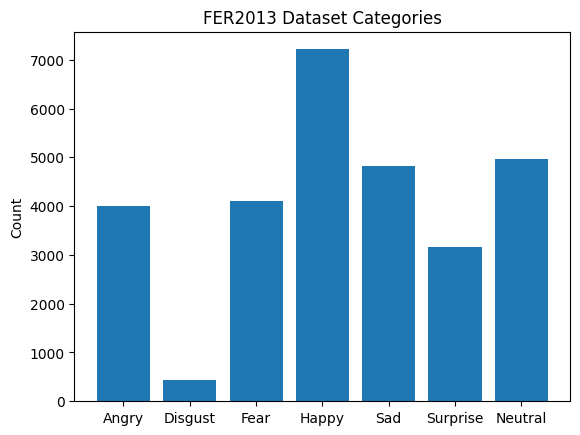

In [5]:
categories = ('Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral')
y_pos = numpy.arange(len(categories))

counts = []
for label in range(len(categories)):
    label_str = str(label)
    count = categories_count[label_str]
    counts.append(count)

# Draw histogram
plt.bar(y_pos, counts, align='center')
plt.xticks(y_pos, categories)
plt.ylabel('Count')
plt.title('FER2013 Dataset Categories')

plt.show()

In [6]:

# Split dataset into train set and test set
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.reshape(len(x_train), 48, 48,1 )
x_test = x_test.reshape(len(x_test), 48, 48,1 )

print(x_train.shape)
print(x_test.shape)

(22967, 48, 48, 1)
(5742, 48, 48, 1)


In [7]:

from tensorflow import keras

model =keras.Sequential()

model.add(Conv2D(176, kernel_size=(3, 3), activation='relu', input_shape=(48,48, 1),))
model.add(Conv2D(176, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(352, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(352, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(704, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(704, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(1048, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(1048, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(1048, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(704, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(352, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',optimizer=Adam(learning_rate=0.001,),metrics=['accuracy'])


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 176)       1760      
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 176)       278960    
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 176)      704       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 176)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 176)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 352)       5

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.0000001,
    patience=0,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5)

In [10]:
history = model.fit(x_train,y_train,epochs=100,batch_size=176,validation_data=(x_test,y_test), callbacks=[early_stopping, reduce_learning_rate])

Epoch 1/100
131/131 [==============================] - 118s 621ms/step - loss: 2.1325 - accuracy: 0.1997 - val_loss: 1.8528 - val_accuracy: 0.2539 - lr: 0.0010
Epoch 2/100
131/131 [==============================] - 71s 541ms/step - loss: 1.8281 - accuracy: 0.2335 - val_loss: 1.8201 - val_accuracy: 0.2541 - lr: 0.0010
Epoch 3/100
131/131 [==============================] - 71s 541ms/step - loss: 1.8137 - accuracy: 0.2478 - val_loss: 1.7929 - val_accuracy: 0.2541 - lr: 0.0010
Epoch 4/100
131/131 [==============================] - 72s 546ms/step - loss: 1.7992 - accuracy: 0.2531 - val_loss: 1.8248 - val_accuracy: 0.2565 - lr: 0.0010
Epoch 5/100
131/131 [==============================] - 71s 540ms/step - loss: 1.7630 - accuracy: 0.2793 - val_loss: 1.7045 - val_accuracy: 0.3103 - lr: 0.0010
Epoch 6/100
131/131 [==============================] - 72s 546ms/step - loss: 1.6846 - accuracy: 0.3206 - val_loss: 1.6848 - val_accuracy: 0.3133 - lr: 0.0010
Epoch 7/100
131/131 [========================

In [11]:
y_prob =model.predict(x_test)
y_pred=y_prob.argmax(axis=1)

180/180 [==============================] - 8s 35ms/step


In [12]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.6424590734935562

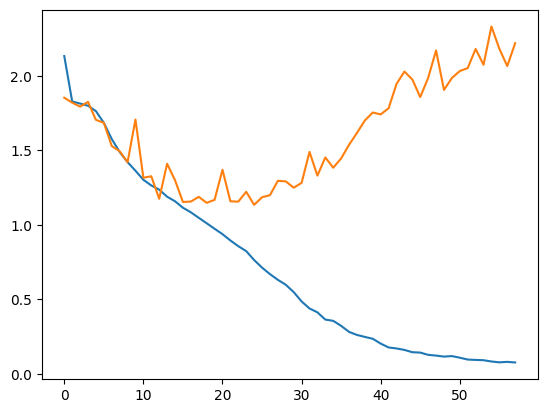

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

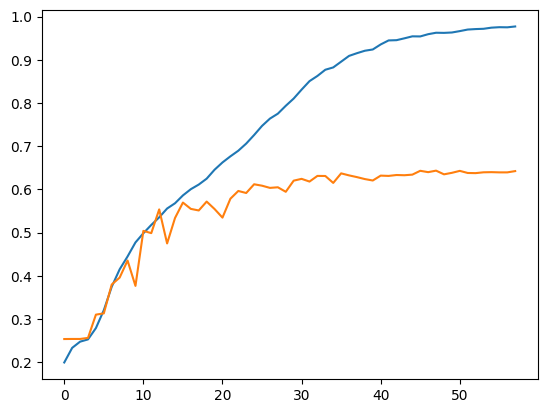

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [15]:
# Generate hard data- data the model wrongly classified
hard_images = []
hard_labels = []

# Make predictions
predictions = model.predict(x_test)
for i, v in enumerate(predictions):
    y_predict = numpy.argmax(v)
    y_real = y_train[i]
    if y_predict != y_real:
        # If predict incorrectly, append to array
        image = x_train[i]
        hard_image = image.reshape(1, 48, 48, 1)
        hard_images.append(image)
        hard_labels.append(y_real)

x_hard = numpy.array(hard_images)
y_hard = numpy.array(hard_labels)

print(x_hard.shape)
print(y_hard.shape)

180/180 [==============================] - 6s 32ms/step
(4725, 48, 48, 1)
(4725,)


In [16]:
# Train the model on hard data
x_hard_train, x_hard_test, y_hard_train, y_hard_test = train_test_split(x_hard, y_hard, test_size=0.2)
history = model.fit(x_hard_train,
                        y_hard_train,
                        batch_size=176,
                        epochs=100,
                        validation_data=(x_hard_test, y_hard_test),
                        callbacks=[early_stopping, reduce_learning_rate])

Epoch 1/100
22/22 [==============================] - 26s 1s/step - loss: 0.0806 - accuracy: 0.9735 - val_loss: 0.0107 - val_accuracy: 0.9958 - lr: 4.7830e-04
Epoch 2/100
22/22 [==============================] - 12s 558ms/step - loss: 0.0492 - accuracy: 0.9849 - val_loss: 0.0087 - val_accuracy: 0.9968 - lr: 4.7830e-04
Epoch 3/100
22/22 [==============================] - 12s 557ms/step - loss: 0.0594 - accuracy: 0.9804 - val_loss: 0.0127 - val_accuracy: 0.9947 - lr: 4.7830e-04
Epoch 4/100
22/22 [==============================] - 12s 556ms/step - loss: 0.0513 - accuracy: 0.9862 - val_loss: 0.0140 - val_accuracy: 0.9958 - lr: 4.7830e-04
Epoch 5/100
22/22 [==============================] - 12s 556ms/step - loss: 0.0531 - accuracy: 0.9823 - val_loss: 0.0193 - val_accuracy: 0.9926 - lr: 4.7830e-04
Epoch 6/100
22/22 [==============================] - 12s 557ms/step - loss: 0.0424 - accuracy: 0.9889 - val_loss: 0.0127 - val_accuracy: 0.9968 - lr: 4.7830e-04
Epoch 7/100
22/22 [==================

In [17]:
# Perform data augmentation
from keras.preprocessing.image import ImageDataGenerator
data_generator = ImageDataGenerator(featurewise_center=False,
                                    featurewise_std_normalization=False,
                                    rotation_range=10,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=.1,
                                    horizontal_flip=True)
flow = data_generator.flow(x_train, 
                           y_train, 
                           batch_size=64)

# Train the model again to balance out
history = model.fit(flow,
                        epochs=100,
                        validation_data=(x_test, y_test),
                        callbacks=[early_stopping, reduce_learning_rate])

Epoch 1/100
359/359 [==============================] - 98s 251ms/step - loss: 1.2365 - accuracy: 0.5778 - val_loss: 1.0175 - val_accuracy: 0.6304 - lr: 3.8742e-04
Epoch 2/100
359/359 [==============================] - 79s 221ms/step - loss: 1.0886 - accuracy: 0.6159 - val_loss: 1.0244 - val_accuracy: 0.6409 - lr: 3.8742e-04
Epoch 3/100
359/359 [==============================] - 84s 233ms/step - loss: 1.0645 - accuracy: 0.6242 - val_loss: 0.9923 - val_accuracy: 0.6442 - lr: 3.8742e-04
Epoch 4/100
359/359 [==============================] - 84s 233ms/step - loss: 1.0387 - accuracy: 0.6321 - val_loss: 0.9606 - val_accuracy: 0.6595 - lr: 3.8742e-04
Epoch 5/100
359/359 [==============================] - 84s 233ms/step - loss: 1.0062 - accuracy: 0.6480 - val_loss: 0.9391 - val_accuracy: 0.6632 - lr: 3.8742e-04
Epoch 6/100
359/359 [==============================] - 84s 233ms/step - loss: 0.9919 - accuracy: 0.6482 - val_loss: 0.9772 - val_accuracy: 0.6526 - lr: 3.8742e-04
Epoch 7/100
359/359 [=

180/180 [==============================] - 6s 32ms/step


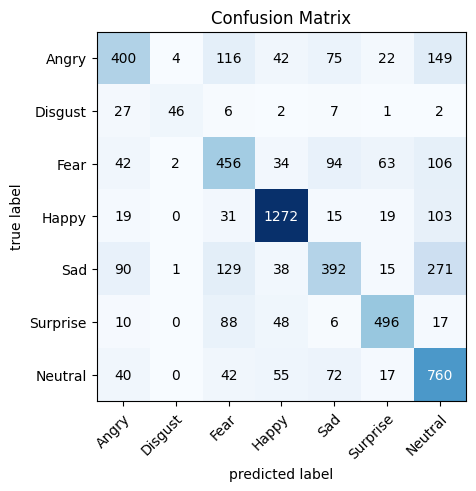

In [18]:
!pip install -U mlxtend > /dev/null 2>&1

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# Make predictions
predictions = model.predict(x_test)
y_predict = numpy.argmax(predictions, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_predict)

# Display confusion matrix
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, class_names=class_names)
plt.title('Confusion Matrix')
plt.show()